# Creating an End-To-End Dialogue System

In this notebook, the seq2seq model is used to build a generative model.

To begin, download the data ZIP file from [here](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html) and place it under the current directory. 

After that, let’s import some necessities.

In [1]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/My Drive")

Mounted at /content/drive


# The Cornell Movie-Dialogs Corpus 

The next move is to reformat our data file and load the data into functional structures. 

The Cornell Movie-Dialogs Corpus contains 220,579 conversational exchanges between 10,292 pairs of movie characters, 9,035 characters from 617 movies, and 304,713 total utterances. This dataset is large with a wide variety of language formality, time periods, and other variables. Our hope is that this variety will make our model responsive to a wide range of queries.

In [3]:
#Loading the data
lines = open('/content/drive/My Drive/lab12/cornell movie-dialogs corpus/movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open('/content/drive/My Drive/lab12/cornell movie-dialogs corpus/movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each id with its line
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)

print(pairs[0])

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.

['Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.', "Well, I thought we'd start with pronunciation, if that's okay with you."]


We'll format data file with a question sentence and an answer sentence pair on each line for convenience.  Before we are ready to use this data, we must perform some preprocessing.


In [4]:
def preprocess(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p

replaced_pairs = preprocess(pairs)
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table 
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuations 
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove numbers 
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]


The parsing of the raw movie lines.txt data file is made simpler with the following functions. We add the start and end tokens to our sentences. We also need to find the maximum length.



In [5]:
# adding the start and end tokens to our utterances
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token # creating new i[0] and i[1] using previous i[0] and i[1]
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
print(tokenized_pairs[:5])
print()

# finding the maximum length for questions and answers
# we caculate the max length that covers 80% of the data 
def max_length(pairs,prct):
    # Create a list of all the utterances
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions) # list of lengths of all the questions in the list questions
    length_answers = list(len(d.split()) for d in answers)

    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len of questions for training: ', max_len_q)
print('max-len of answers for training: ', max_len_a)

[['<startseq> can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again <endseq>', '<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>'], ['<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>', '<startseq> not the hacking and gagging and spitting part please <endseq>'], ['<startseq> not the hacking and gagging and spitting part please <endseq>', '<startseq> okay then how about we try out some french cuisine saturday night <endseq>'], ['<startseq> you are asking me out that is so cute that is your name again <endseq>', '<startseq> forget it <endseq>'], ['<startseq> no no it is my fault we did not have a proper introduction <endseq>', '<startseq> cameron <endseq>']]

max-len of questions for training:  18
max-len of answers for training:  18


The next step is to build a vocabulary and save query/response pairs. 
It's worth noting that we're dealing with word sequences that don't have an implicit mapping to a discrete numerical space. As a result, we must build one by assigning an index value to each unique word in our dataset.

We are going to create our vocabulary. Trimming rarely used words from our vocabulary is another strategy for achieving faster convergence during preparation. The complexity of the function that the model must learn to approximate will be lowered as the feature space is reduced.

In [39]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen. maxlen is 80% length of all questions
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

# making a vocabulary of the words that occur more than word_count_threshold 
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j) # all questions,answers together

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    less_frequent_words = [w for w in word_counts if word_counts[w] < word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab , less_frequent_words,word_counts

# each word in the vocabulary must be used in the data at least 20 times
new_vocab,less_frequent_words, word_counts= create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
for v in new_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        new_vocab.remove(v) 

new_vocab = sorted(new_vocab)[1:]
new_vocab[10:15]

Short vocab size: 14524 


['ab', 'abandon', 'abandoned', 'abba', 'abbe']

In [43]:
word_counts["fart"]

14

In [7]:
vocab_len = len(new_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len


14500

In [ ]:
#print(less_frequent_words)

['pronunciation', 'cesc', 'tete', 'progressing', 'instructor', 'guillermo', 'endless', 'babble', 'pastels', 'oily', 'lowenbraus', 'prada', 'gigglepuss', 'clouted', 'fen', 'hedgepig', 'unbalanced', 'fruitloop', 'kats', 'padua', 'undersexed', 'clint', 'eastwood', 'consecrate', 'shrew', 'biancas', 'mewling', 'rampalian', 'wretch', 'thrives', 'katarina', 'schoolwide', 'smokers', 'assail', 'buttholus', 'extremus', 'altar', 'prisonmovie', 'headway', 'crazed', 'upped', 'limothe', 'bathes', 'mandella', 'attempted', 'heterosexuality', 'efforts', 'speedy', 'consuming', 'suburban', 'backfired', 'puked', 'bastion', 'progressed', 'fullon', 'burnside', 'screwboy', 'laundromat', 'talker', 'fenders', 'raincoats', 'mystique', 'wholesome', 'upchuck', 'reflex', 'sprung', 'cruised', 'dazzled', 'fallacy', 'hearsay', 'peas', 'amazingly', 'selfassured', 'scurvys', 'fender', 'strat', 'veggie', 'grooming', 'rubbed', 'blaise', 'expressing', 'spectator', 'perceive', 'tempestuous', 'heinous', 'macbeth', 'nonsmoke

We are going to create a dataset of pairs without the trimmed words.

In [ ]:
def progressBar(value, endvalue, bar_length=20, job=''):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} : [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

In [9]:
# keeping the pairs with words in the vocab
def trimRareWords(voc, pairs):
    # Filtering out the pairs with the oov words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        #  input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        #  output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        if keep_input and keep_output: # if both true
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(new_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

In [10]:
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

114938

In [ ]:
print(pairs_final_train[0])

['<startseq> not the hacking and gagging and spitting part please <endseq>', '<startseq> okay then how about we try out some french cuisine saturday night <endseq>']


# Embedding layer

Our models will eventually expect numerical tensors as inputs, despite the fact that we put a lot of effort into preparing and massaging our data into a nice vocabulary object and list of sentence pairs. The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.

In [11]:
test = False
GRU_units = 50
batch_size = 32
emb_dim = 50
init_lr = 0.001

#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(new_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0,  padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

# Making the embedding matrix
def make_embedding_layer(embedding_dim=50, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        embeddings_index = {} 
        f = open(os.path.join('/content/drive/My Drive/lab12/cornell movie-dialogs corpus/glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loaded!')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words that are not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=50, glove=not test)

Loading glove...
GloVe  50  loaded!


# Seq2Seq Model



A sequence-to-sequence (seq2seq) model is at the core of our model. The purpose of a seq2seq model is to use a fixed-sized sequence as an input and generate a variable-length sequence as an output.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) found that we can do this task by combining two different recurrent neural nets. One  RNN serves as an encoder, converting a variable-length input sequence to a fixed-length context vector. This context vector (the RNN's final hidden layer) contain semantic knowledge about the query sentence that the system receives.



# Encoder

The encoder RNN iterates through the input sentence one token at a time, producing an "output" vector and a "hidden state" vector at each time step.  The output vector is recorded while the hidden state vector is transferred to the next time step. The encoder converts the context it observed at each point in the sequence into a set of points in a high-dimensional space, which the decoder can use to produce a meaningful output for the task at hand.

A multi-layered Gated Recurrent Unit, created by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf), is at the centre of our encoder. We'll use a bidirectional version of the GRU, which effectively means there are two separate RNNs: one fed the input sequence in regular sequential order and the other fed the input sequence in reverse order. At each time point, the outputs of each network are added together.

***For the first task you need to define a bidirectional GRU and pass the embedding into the GRU. ***

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units

        #  pass the embedding into a bidirectional version of the GRU - as you can see in the call() method below, you can use just 1 GRU layer but could experiment with more
        self.embeddings = embeddings
        self.Bidirectional1 = Bidirectional(GRU(self.enc_units,return_sequences = True, return_state = False)) 
        self.Bidirectional2 = Bidirectional(GRU(self.enc_units,return_sequences = True, return_state = True)) 
        #                                                                                        
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
            
    def bidirectional(self, bidir, layer, inp, hidden):
        return bidir(layer(inp, initial_state = hidden))
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        x = self.Bidirectional1(x)
        x = self.dropout(x)
        output, state_f,state_b = self.Bidirectional2(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [22]:
encoder = Encoder(vocab_len, 50, GRU_units)


# Decoder

The response utterance is produced token by token by the decoder RNN. It generates the next word in the sequence using the encoder's context vectors and internal hidden states. It keeps producing words until it reaches the end of the sentence, which is represented by an end_token. A common issue with a standard seq2seq decoder is that relying solely on the context vector to encode the meaning of the complete input sequence would almost certainly result in information loss. This is particularly true when dealing with long input sequences, severely restricting our decoder's capabilities.

[Bahdanau et al.](https://arxiv.org/abs/1409.0473) devised an "attention mechanism" that allows the decoder to focus on specific parts of the input sequence rather than using the whole set context at each step to deal with information loss. Attention is determined using the encoder's outputs and the decoder's current hidden state. Since the output attention weights have the same shape as the input sequence, we may multiply them by the encoder outputs to get a weighted amount that shows which sections of the encoder output to focus on.

**For the second task you need to create the decoder with attention. Call the attention layer and use GRUs for decoding.**

In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [24]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # Create the decoder with attention - as you'll see in the call() method below, it will need two GRU layers
        self.attention = BahdanauAttention(self.units)        
        self.decoder_gru_l1 = GRU(self.units,return_sequences=True,return_state = False)
        self.decoder_gru_l2 = GRU(self.units,return_sequences=False,return_state = True)
        self.dropout = Dropout(0.2)
                                       
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_len, 50, GRU_units)


# Evaluation

We can now write functions to evaluate a string input sentence now that we've established our decoding process. The evaluate function is in charge of the low-level handling of the input sentence. The sentence is first formatted as an input batch of word indexes. To prepare the tensor for our models, we convert the words of the sentence to their corresponding indexes and transpose the dimensions. Our system's user interface is called answer. Our text is normalised in the same way that our training data is, and then fed into the evaluate function to generate a decoded output sentence and attention weights.

In [48]:
import unicodedata
import matplotlib.ticker as ticker

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(1, 1, 1)
    print("Attention weights")
    print(attention)
    cax = ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(cax)
    plt.show()
    print()

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

# Greedy decoding

Greedy decoding is a decoding method in which we simply choose the highest softmax value word from decoder output for each time stage. On a single time-step stage, this decoding method is optimal. It is common in neural machine translation systems to use a beam-search to sample the probabilities for the words in the sequence output by the model.

The wider the beam width, the more exhaustive the search, and, it is believed, the better the results.

The results showed that a modest beam-width of 3-5 performed the best, which could be improved only very slightly through the use of length penalties. 

In [27]:
def beam_search(sentence, k=5, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):

    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

# Training procedure

# Masked loss

We can't simply consider all elements of the tensor when evaluating loss because we're dealing with batches of padded sequences. Based on our decoder's output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor, we define a function to measure our loss.

In [28]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [34]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


# Single training iteration

The algorithm for a single training iteration is contained in the train_step function (a single batch of inputs). To help with convergence, we'll use teacher forcing. This means that we use the current target word as the decoder's next input rather than the decoder's current guess in some probabilities. This technique serves as decoder training wheels, allowing for more effective training. However, since the decoder may not have had enough time to truly craft its own output sequences during training, teacher forcing can lead to model instability during inference. 



In [30]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [31]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 150 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1


We are creating a test_bot to monitor our training in every time step.

In [32]:
def test_bot(k = 5, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')

    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What is your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
  
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

# Training iterations

It's finally time to link the entire training procedure to the data. Given the passed models, optimizers, data, and so on, the function is responsible for running n iterations of training. We've already done the heavy lifting with the train_step function, so this function is self-explanatory.

One thing to keep in mind is that when we save our model, the encoder and decoder parameters, the optimizer parameters, the loss, the iteration, and so on are all saved. This method of saving the model will give us the most flexibility with the checkpoint. We can use the model parameters to run inference after loading a checkpoint, or we can begin training where we left off.

Epoch 1 Batch 598 Loss: 2.0920
Epoch 1 Batch 1196 Loss: 2.3583
Epoch 1 Batch 1794 Loss: 2.1536
Epoch 1 Batch 2392 Loss: 2.1540
Epoch 1 Batch 2990 Loss: 1.9232
Epoch 1 Batch 3588 Loss: 2.2983

*** Epoch 1 Loss 2.1100 ***

####################
Greedy| Q: Hello   A: i am not 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  1
Time  230.456 sec

Epoch 2 Batch 598 Loss: 1.7529
Epoch 2 Batch 1196 Loss: 2.3933
Epoch 2 Batch 1794 Loss: 2.3165
Epoch 2 Batch 2392 Loss: 2.3372
Epoch 2 Batch 2990 Loss: 1.7709
Epoch 2 Batch 3588 Loss: 2.2031

*** Epoch 2 Loss 1.8703 ***

####################
Greedy| Q: Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not a little of the way 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not a li

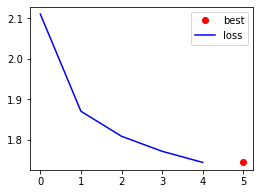

Best epoch so far:  5
Time  187.859 sec

Epoch 6 Batch 598 Loss: 1.5532
Epoch 6 Batch 1196 Loss: 1.8894
Epoch 6 Batch 1794 Loss: 1.7936
Epoch 6 Batch 2392 Loss: 1.9017
Epoch 6 Batch 2990 Loss: 1.6477
Epoch 6 Batch 3588 Loss: 1.9822

*** Epoch 6 Loss 1.7221 ***

####################
Greedy| Q: Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################
check point saved!
Best epoch so far:  6
Time  186.748 sec

Epoch 7 Batch 598 Loss: 1.6512
Epoch 7 Batch 1196 Loss: 2.1658
Epoch 7 Batch 1794 Loss: 2.1073
Epoch 7 Batch 2392 Loss: 2.1726
Epoch 7 Batch 2990 Loss: 1.5243
Epoch 7 Batch 3588 Loss: 1.9777

*** Epoch 7 Loss 1.7049 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  

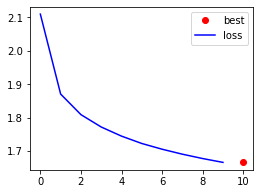

Best epoch so far:  10
Time  188.788 sec

Epoch 11 Batch 598 Loss: 1.4997
Epoch 11 Batch 1196 Loss: 1.8288
Epoch 11 Batch 1794 Loss: 1.6875
Epoch 11 Batch 2392 Loss: 1.9043
Epoch 11 Batch 2990 Loss: 1.6028
Epoch 11 Batch 3588 Loss: 1.9257

*** Epoch 11 Loss 1.6546 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  11
Time  188.997 sec

Epoch 12 Batch 598 Loss: 1.6154
Epoch 12 Batch 1196 Loss: 2.0841
Epoch 12 Batch 1794 Loss: 1.9405
Epoch 12 Batch 2392 Loss: 2.1038
Epoch 12 Batch 2990 Loss: 1.4401
Epoch 12 Batch 3588 Loss: 1.8545

*** Epoch 12 Loss 1.6458 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing 

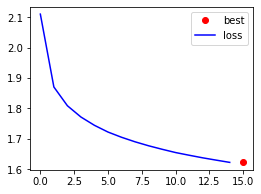

Best epoch so far:  15
Time  186.714 sec

Epoch 16 Batch 598 Loss: 1.4244
Epoch 16 Batch 1196 Loss: 1.8614
Epoch 16 Batch 1794 Loss: 1.6833
Epoch 16 Batch 2392 Loss: 1.9220
Epoch 16 Batch 2990 Loss: 1.6167
Epoch 16 Batch 3588 Loss: 1.7810

*** Epoch 16 Loss 1.6156 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  16
Time  187.507 sec

Epoch 17 Batch 598 Loss: 1.5299
Epoch 17 Batch 1196 Loss: 1.7178
Epoch 17 Batch 1794 Loss: 1.7112
Epoch 17 Batch 2392 Loss: 1.7923
Epoch 17 Batch 2990 Loss: 1.5588
Epoch 17 Batch 3588 Loss: 1.6175

*** Epoch 17 Loss 1.6089 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doi

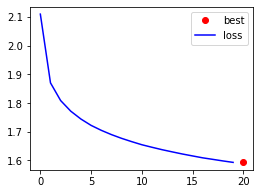

Best epoch so far:  20
Time  186.966 sec

Epoch 21 Batch 598 Loss: 1.3767
Epoch 21 Batch 1196 Loss: 1.9130
Epoch 21 Batch 1794 Loss: 1.8186
Epoch 21 Batch 2392 Loss: 1.9462
Epoch 21 Batch 2990 Loss: 1.6363
Epoch 21 Batch 3588 Loss: 1.8519

*** Epoch 21 Loss 1.5887 ***

####################
Greedy| Q: Hello   A: hi 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  21
Time  184.888 sec

Epoch 22 Batch 598 Loss: 1.4622
Epoch 22 Batch 1196 Loss: 1.7018
Epoch 22 Batch 1794 Loss: 1.6660
Epoch 22 Batch 2392 Loss: 1.8214
Epoch 22 Batch 2990 Loss: 1.4802
Epoch 22 Batch 3588 Loss: 1.6566

*** Epoch 22 Loss 1.5835 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am n

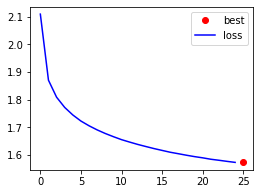

Best epoch so far:  25
Time  184.336 sec

Epoch 26 Batch 598 Loss: 1.4063
Epoch 26 Batch 1196 Loss: 1.9736
Epoch 26 Batch 1794 Loss: 1.9251
Epoch 26 Batch 2392 Loss: 1.8284
Epoch 26 Batch 2990 Loss: 1.6706
Epoch 26 Batch 3588 Loss: 1.9138

*** Epoch 26 Loss 1.5689 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  26
Time  183.916 sec

Epoch 27 Batch 598 Loss: 1.4438
Epoch 27 Batch 1196 Loss: 1.7307
Epoch 27 Batch 1794 Loss: 1.6056
Epoch 27 Batch 2392 Loss: 1.8435
Epoch 27 Batch 2990 Loss: 1.4829
Epoch 27 Batch 3588 Loss: 1.7045

*** Epoch 27 Loss 1.5648 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doing ?  A: i am 

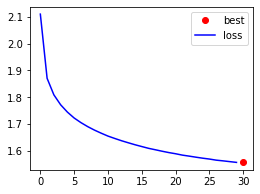

Best epoch so far:  30
Time  184.259 sec

Epoch 31 Batch 598 Loss: 1.2574
Epoch 31 Batch 1196 Loss: 2.1018
Epoch 31 Batch 1794 Loss: 1.8604
Epoch 31 Batch 2392 Loss: 1.9075
Epoch 31 Batch 2990 Loss: 1.6169
Epoch 31 Batch 3588 Loss: 1.9148

*** Epoch 31 Loss 1.5537 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doing ?  A: i am going to be a little 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a little 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  31
Time  183.357 sec

Epoch 32 Batch 598 Loss: 1.3595
Epoch 32 Batch 1196 Loss: 1.7772
Epoch 32 Batch 1794 Loss: 1.6275
Epoch 32 Batch 2392 Loss: 1.8722
Epoch 32 Batch 2990 Loss: 1.5242
Epoch 32 Batch 3588 Loss: 1.6365

*** Epoch 32 Loss 1.5510 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doi

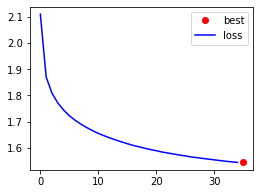

Best epoch so far:  35
Time  184.010 sec

Epoch 36 Batch 598 Loss: 1.2946
Epoch 36 Batch 1196 Loss: 2.1282
Epoch 36 Batch 1794 Loss: 1.8437
Epoch 36 Batch 2392 Loss: 1.9139
Epoch 36 Batch 2990 Loss: 1.6306
Epoch 36 Batch 3588 Loss: 1.8251

*** Epoch 36 Loss 1.5416 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doing ?  A: i am a little 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a little bit 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  36
Time  185.391 sec

Epoch 37 Batch 598 Loss: 1.3220
Epoch 37 Batch 1196 Loss: 1.8515
Epoch 37 Batch 1794 Loss: 1.7822
Epoch 37 Batch 2392 Loss: 1.8775
Epoch 37 Batch 2990 Loss: 1.5835
Epoch 37 Batch 3588 Loss: 1.7524

*** Epoch 37 Loss 1.5398 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a little 
%
Greedy| Q: What are you doing ?  A:

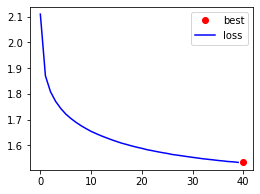

Best epoch so far:  40
Time  184.942 sec

Epoch 41 Batch 598 Loss: 1.3486
Epoch 41 Batch 1196 Loss: 2.0833
Epoch 41 Batch 1794 Loss: 1.9875
Epoch 41 Batch 2392 Loss: 1.8794
Epoch 41 Batch 2990 Loss: 1.6076
Epoch 41 Batch 3588 Loss: 1.8299

*** Epoch 41 Loss 1.5326 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am a little bit 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  41
Time  183.031 sec

Epoch 42 Batch 598 Loss: 1.3678
Epoch 42 Batch 1196 Loss: 1.9272
Epoch 42 Batch 1794 Loss: 1.8866
Epoch 42 Batch 2392 Loss: 1.7833
Epoch 42 Batch 2990 Loss: 1.6070
Epoch 42 Batch 3588 Loss: 1.8321

*** Epoch 42 Loss 1.5308 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the police 
%
Greedy| Q: What are you doing ?  A: i am not g

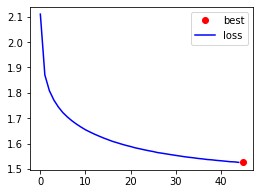

Best epoch so far:  45
Time  187.782 sec

Epoch 46 Batch 598 Loss: 1.3985
Epoch 46 Batch 1196 Loss: 1.9840
Epoch 46 Batch 1794 Loss: 1.9492
Epoch 46 Batch 2392 Loss: 1.8581
Epoch 46 Batch 2990 Loss: 1.5319
Epoch 46 Batch 3588 Loss: 1.8585

*** Epoch 46 Loss 1.5247 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the police 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a little 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  46
Time  189.278 sec

Epoch 47 Batch 598 Loss: 1.2274
Epoch 47 Batch 1196 Loss: 2.0644
Epoch 47 Batch 1794 Loss: 1.8440
Epoch 47 Batch 2392 Loss: 1.8798
Epoch 47 Batch 2990 Loss: 1.5616
Epoch 47 Batch 3588 Loss: 1.8642

*** Epoch 47 Loss 1.5226 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the manual 
%
Gr

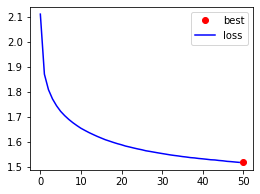

Best epoch so far:  50
Time  188.929 sec

Epoch 51 Batch 598 Loss: 1.3963
Epoch 51 Batch 1196 Loss: 2.0304
Epoch 51 Batch 1794 Loss: 1.9416
Epoch 51 Batch 2392 Loss: 1.9974
Epoch 51 Batch 2990 Loss: 1.5332
Epoch 51 Batch 3588 Loss: 1.9324

*** Epoch 51 Loss 1.5173 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a little while you were in the bathroom 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  51
Time  190.818 sec

Epoch 52 Batch 598 Loss: 1.2737
Epoch 52 Batch 1196 Loss: 2.0623
Epoch 52 Batch 1794 Loss: 1.8296
Epoch 52 Batch 2392 Loss: 1.8985
Epoch 52 Batch 2990 Loss: 1.5788
Epoch 52 Batch 3588 Loss: 1.7660

*** Epoch 52 Loss 1.5159 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the

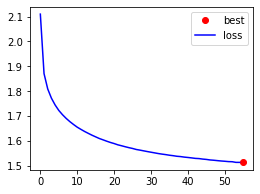

Best epoch so far:  55
Time  187.694 sec

Epoch 56 Batch 598 Loss: 1.4122
Epoch 56 Batch 1196 Loss: 1.9560
Epoch 56 Batch 1794 Loss: 1.9256
Epoch 56 Batch 2392 Loss: 1.9520
Epoch 56 Batch 2990 Loss: 1.5443
Epoch 56 Batch 3588 Loss: 1.8324

*** Epoch 56 Loss 1.5121 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  56
Time  189.483 sec

Epoch 57 Batch 598 Loss: 1.3295
Epoch 57 Batch 1196 Loss: 2.0144
Epoch 57 Batch 1794 Loss: 1.9669
Epoch 57 Batch 2392 Loss: 1.8659
Epoch 57 Batch 2990 Loss: 1.5516
Epoch 57 Batch 3588 Loss: 1.7949

*** Epoch 57 Loss 1.5103 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the police are going to the police 
%
Greedy| Q: What are you doing ?

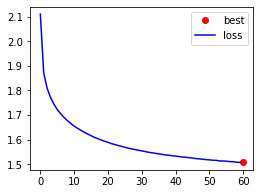

Best epoch so far:  60
Time  187.239 sec

Epoch 61 Batch 598 Loss: 1.4096
Epoch 61 Batch 1196 Loss: 1.8816
Epoch 61 Batch 1794 Loss: 1.8924
Epoch 61 Batch 2392 Loss: 1.9818
Epoch 61 Batch 2990 Loss: 1.5197
Epoch 61 Batch 3588 Loss: 1.8189

*** Epoch 61 Loss 1.5066 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am a little 
%
Greedy| Q: What are you doing ?  A: i am not 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  61
Time  185.935 sec

Epoch 62 Batch 598 Loss: 1.3774
Epoch 62 Batch 1196 Loss: 1.9757
Epoch 62 Batch 1794 Loss: 1.9255
Epoch 62 Batch 2392 Loss: 1.8591
Epoch 62 Batch 2990 Loss: 1.4908
Epoch 62 Batch 3588 Loss: 1.8081

*** Epoch 62 Loss 1.5054 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%


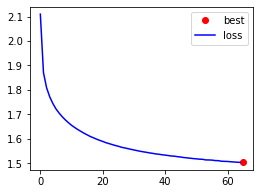

Best epoch so far:  65
Time  188.342 sec

Epoch 66 Batch 598 Loss: 1.4239
Epoch 66 Batch 1196 Loss: 1.8218
Epoch 66 Batch 1794 Loss: 1.8977
Epoch 66 Batch 2392 Loss: 1.9590
Epoch 66 Batch 2990 Loss: 1.4500
Epoch 66 Batch 3588 Loss: 1.7527

*** Epoch 66 Loss 1.5017 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  66
Time  187.578 sec

Epoch 67 Batch 598 Loss: 1.3930
Epoch 67 Batch 1196 Loss: 2.0043
Epoch 67 Batch 1794 Loss: 1.9289
Epoch 67 Batch 2392 Loss: 1.9832
Epoch 67 Batch 2990 Loss: 1.5034
Epoch 67 Batch 3588 Loss: 1.9514

*** Epoch 67 Loss 1.5011 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am going to d

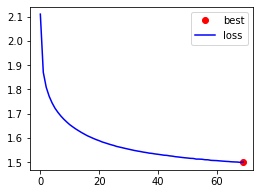

Best epoch so far:  69
Time  185.297 sec

Epoch 71 Batch 598 Loss: 1.4808
Epoch 71 Batch 1196 Loss: 1.7700
Epoch 71 Batch 1794 Loss: 1.8619
Epoch 71 Batch 2392 Loss: 1.9628
Epoch 71 Batch 2990 Loss: 1.3489
Epoch 71 Batch 3588 Loss: 1.7067

*** Epoch 71 Loss 1.5004 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  69
Time  184.060 sec

Epoch 72 Batch 598 Loss: 1.4115
Epoch 72 Batch 1196 Loss: 1.9418
Epoch 72 Batch 1794 Loss: 1.9025
Epoch 72 Batch 2392 Loss: 1.9402
Epoch 72 Batch 2990 Loss: 1.5378
Epoch 72 Batch 3588 Loss: 1.7994

*** Epoch 72 Loss 1.4977 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the police 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What

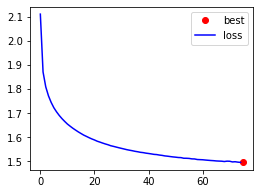

Best epoch so far:  75
Time  184.107 sec

Epoch 76 Batch 598 Loss: 1.4913
Epoch 76 Batch 1196 Loss: 1.7714
Epoch 76 Batch 1794 Loss: 1.7569
Epoch 76 Batch 2392 Loss: 1.9618
Epoch 76 Batch 2990 Loss: 1.3124
Epoch 76 Batch 3588 Loss: 1.6504

*** Epoch 76 Loss 1.4947 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to be a lot of philosophy 
%
Greedy| Q: What are you doing ?  A: i am going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am a navy 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  76
Time  187.818 sec

Epoch 77 Batch 598 Loss: 1.3937
Epoch 77 Batch 1196 Loss: 1.8721
Epoch 77 Batch 1794 Loss: 1.8594
Epoch 77 Batch 2392 Loss: 1.9738
Epoch 77 Batch 2990 Loss: 1.4964
Epoch 77 Batch 3588 Loss: 1.8230

*** Epoch 77 Loss 1.4933 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am a feeling 
%
Greedy| Q: What are you do

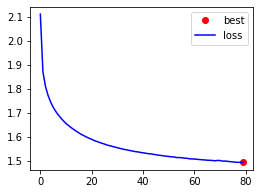

Best epoch so far:  79
Time  181.910 sec

Epoch 81 Batch 598 Loss: 1.4385
Epoch 81 Batch 1196 Loss: 1.5811
Epoch 81 Batch 1794 Loss: 1.6001
Epoch 81 Batch 2392 Loss: 1.7135
Epoch 81 Batch 2990 Loss: 1.3775
Epoch 81 Batch 3588 Loss: 1.3800

*** Epoch 81 Loss 1.4911 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  81
Time  182.961 sec

Epoch 82 Batch 598 Loss: 1.4160
Epoch 82 Batch 1196 Loss: 1.7864
Epoch 82 Batch 1794 Loss: 1.8980
Epoch 82 Batch 2392 Loss: 1.9645
Epoch 82 Batch 2990 Loss: 1.4441
Epoch 82 Batch 3588 Loss: 1.7193

*** Epoch 82 Loss 1.4902 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy|

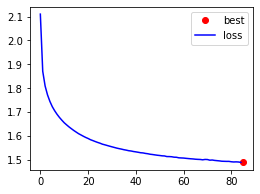

Best epoch so far:  85
Time  184.370 sec

Epoch 86 Batch 598 Loss: 1.4005
Epoch 86 Batch 1196 Loss: 1.6122
Epoch 86 Batch 1794 Loss: 1.5781
Epoch 86 Batch 2392 Loss: 1.7310
Epoch 86 Batch 2990 Loss: 1.3431
Epoch 86 Batch 3588 Loss: 1.4638

*** Epoch 86 Loss 1.4881 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a sin 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  86
Time  183.626 sec

Epoch 87 Batch 598 Loss: 1.4601
Epoch 87 Batch 1196 Loss: 1.7625
Epoch 87 Batch 1794 Loss: 1.9078
Epoch 87 Batch 2392 Loss: 1.9459
Epoch 87 Batch 2990 Loss: 1.3560
Epoch 87 Batch 3588 Loss: 1.7086

*** Epoch 87 Loss 1.4894 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Gre

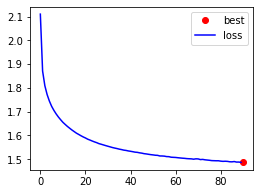

Best epoch so far:  90
Time  185.856 sec

Epoch 91 Batch 598 Loss: 1.4077
Epoch 91 Batch 1196 Loss: 1.6486
Epoch 91 Batch 1794 Loss: 1.5375
Epoch 91 Batch 2392 Loss: 1.7772
Epoch 91 Batch 2990 Loss: 1.3466
Epoch 91 Batch 3588 Loss: 1.5299

*** Epoch 91 Loss 1.4855 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  91
Time  189.732 sec

Epoch 92 Batch 598 Loss: 1.4665
Epoch 92 Batch 1196 Loss: 1.7554
Epoch 92 Batch 1794 Loss: 1.7506
Epoch 92 Batch 2392 Loss: 1.9379
Epoch 92 Batch 2990 Loss: 1.3140
Epoch 92 Batch 3588 Loss: 1.6400

*** Epoch 92 Loss 1.4847 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Gre

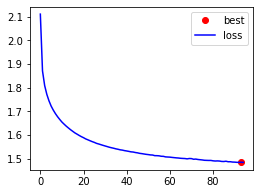

Best epoch so far:  93
Time  184.125 sec

Epoch 96 Batch 598 Loss: 1.3459
Epoch 96 Batch 1196 Loss: 1.6958
Epoch 96 Batch 1794 Loss: 1.5707
Epoch 96 Batch 2392 Loss: 1.8232
Epoch 96 Batch 2990 Loss: 1.4209
Epoch 96 Batch 3588 Loss: 1.5351

*** Epoch 96 Loss 1.4836 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to the police 
%
Greedy| Q: What are you doing ?  A: i am not going to be a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am a dentist 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  96
Time  183.478 sec

Epoch 97 Batch 598 Loss: 1.4306
Epoch 97 Batch 1196 Loss: 1.5939
Epoch 97 Batch 1794 Loss: 1.6080
Epoch 97 Batch 2392 Loss: 1.6871
Epoch 97 Batch 2990 Loss: 1.3762
Epoch 97 Batch 3588 Loss: 1.4057

*** Epoch 97 Loss 1.4837 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?

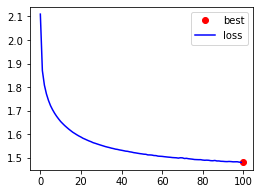

Best epoch so far:  100
Time  183.727 sec

Epoch 101 Batch 598 Loss: 1.3107
Epoch 101 Batch 1196 Loss: 1.7774
Epoch 101 Batch 1794 Loss: 1.6973
Epoch 101 Batch 2392 Loss: 1.8469
Epoch 101 Batch 2990 Loss: 1.4655
Epoch 101 Batch 3588 Loss: 1.6720

*** Epoch 101 Loss 1.4815 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of things 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to be a little 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  100
Time  183.280 sec

Epoch 102 Batch 598 Loss: 1.3912
Epoch 102 Batch 1196 Loss: 1.6167
Epoch 102 Batch 1794 Loss: 1.5811
Epoch 102 Batch 2392 Loss: 1.7278
Epoch 102 Batch 2990 Loss: 1.3312
Epoch 102 Batch 3588 Loss: 1.4819

*** Epoch 102 Loss 1.4805 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you

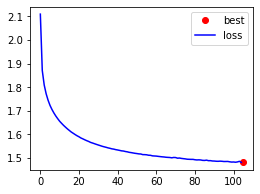

Best epoch so far:  105
Time  182.856 sec

Epoch 106 Batch 598 Loss: 1.3610
Epoch 106 Batch 1196 Loss: 1.8381
Epoch 106 Batch 1794 Loss: 1.8362
Epoch 106 Batch 2392 Loss: 1.7438
Epoch 106 Batch 2990 Loss: 1.5411
Epoch 106 Batch 3588 Loss: 1.7555

*** Epoch 106 Loss 1.4791 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am a cop 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  106
Time  181.743 sec

Epoch 107 Batch 598 Loss: 1.3995
Epoch 107 Batch 1196 Loss: 1.6460
Epoch 107 Batch 1794 Loss: 1.5525
Epoch 107 Batch 2392 Loss: 1.7665
Epoch 107 Batch 2990 Loss: 1.3334
Epoch 107 Batch 3588 Loss: 1.5507

*** Epoch 107 Loss 1.4788 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not sure i am

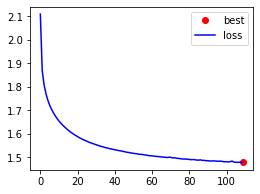

Best epoch so far:  109
Time  184.351 sec

Epoch 111 Batch 598 Loss: 1.2350
Epoch 111 Batch 1196 Loss: 1.9999
Epoch 111 Batch 1794 Loss: 1.7894
Epoch 111 Batch 2392 Loss: 1.8367
Epoch 111 Batch 2990 Loss: 1.5152
Epoch 111 Batch 3588 Loss: 1.7813

*** Epoch 111 Loss 1.4780 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What is your favorite restaurant ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i am sorry i am sorry i am sorry i am sorry i am sorry i am sorry 
####################
check point saved!
Best epoch so far:  111
Time  185.814 sec

Epoch 112 Batch 598 Loss: 1.3297
Epoch 112 Batch 1196 Loss: 1.6923
Epoch 112 Batch 1794 Loss: 1.5800
Epoch 112 Batch 2392 Loss: 1.7984
Epoch 112 Batch 2990 Loss: 1.3708
Epoch 112 Batch 3588 Loss: 1.5200

*** Epoch 112 Loss 1.4776 ***

####################


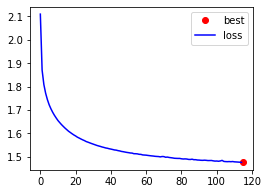

Best epoch so far:  115
Time  187.025 sec

Epoch 116 Batch 598 Loss: 1.2853
Epoch 116 Batch 1196 Loss: 2.0377
Epoch 116 Batch 1794 Loss: 1.7779
Epoch 116 Batch 2392 Loss: 1.8427
Epoch 116 Batch 2990 Loss: 1.5262
Epoch 116 Batch 3588 Loss: 1.6997

*** Epoch 116 Loss 1.4760 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a messenger zoe 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  115
Time  186.890 sec

Epoch 117 Batch 598 Loss: 1.3033
Epoch 117 Batch 1196 Loss: 1.7630
Epoch 117 Batch 1794 Loss: 1.7033
Epoch 117 Batch 2392 Loss: 1.8364
Epoch 117 Batch 2990 Loss: 1.4577
Epoch 117 Batch 3588 Loss: 1.6505

*** Epoch 117 Loss 1.4751 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure i am not

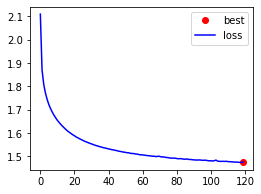

Best epoch so far:  119
Time  184.538 sec

Epoch 121 Batch 598 Loss: 1.3228
Epoch 121 Batch 1196 Loss: 1.9522
Epoch 121 Batch 1794 Loss: 1.9224
Epoch 121 Batch 2392 Loss: 1.8335
Epoch 121 Batch 2990 Loss: 1.5365
Epoch 121 Batch 3588 Loss: 1.7837

*** Epoch 121 Loss 1.4791 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not going to be a lot of checks 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a flaw 
%
Greedy| Q: Do you want to go out ?  A: i am sorry i am sorry 
####################
Best epoch so far:  119
Time  187.520 sec

Epoch 122 Batch 598 Loss: 1.3733
Epoch 122 Batch 1196 Loss: 1.8519
Epoch 122 Batch 1794 Loss: 1.8137
Epoch 122 Batch 2392 Loss: 1.7481
Epoch 122 Batch 2990 Loss: 1.5174
Epoch 122 Batch 3588 Loss: 1.7474

*** Epoch 122 Loss 1.4746 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i 

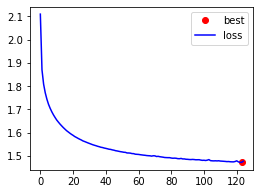

Best epoch so far:  123
Time  186.910 sec

Epoch 126 Batch 598 Loss: 1.3779
Epoch 126 Batch 1196 Loss: 1.9079
Epoch 126 Batch 1794 Loss: 1.8939
Epoch 126 Batch 2392 Loss: 1.8297
Epoch 126 Batch 2990 Loss: 1.4703
Epoch 126 Batch 3588 Loss: 1.7959

*** Epoch 126 Loss 1.4719 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a messenger zoe 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
check point saved!
Best epoch so far:  126
Time  186.058 sec

Epoch 127 Batch 598 Loss: 1.2304
Epoch 127 Batch 1196 Loss: 2.0098
Epoch 127 Batch 1794 Loss: 1.7997
Epoch 127 Batch 2392 Loss: 1.8319
Epoch 127 Batch 2990 Loss: 1.5047
Epoch 127 Batch 3588 Loss: 1.7537

*** Epoch 127 Loss 1.4722 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not sure i am not sure i am not sure

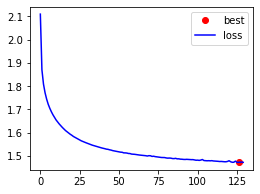

Best epoch so far:  126
Time  186.874 sec

Epoch 131 Batch 598 Loss: 1.3934
Epoch 131 Batch 1196 Loss: 1.9621
Epoch 131 Batch 1794 Loss: 1.8771
Epoch 131 Batch 2392 Loss: 1.9359
Epoch 131 Batch 2990 Loss: 1.4798
Epoch 131 Batch 3588 Loss: 1.8830

*** Epoch 131 Loss 1.4722 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to be a messenger 
%
Greedy| Q: What is your favorite restaurant ?  A: i am sure 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  126
Time  188.936 sec

Epoch 132 Batch 598 Loss: 1.2793
Epoch 132 Batch 1196 Loss: 2.0273
Epoch 132 Batch 1794 Loss: 1.7673
Epoch 132 Batch 2392 Loss: 1.8305
Epoch 132 Batch 2990 Loss: 1.5150
Epoch 132 Batch 3588 Loss: 1.6969

*** Epoch 132 Loss 1.4706 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not

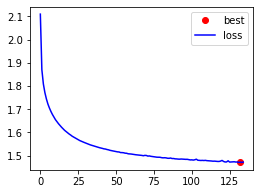

Best epoch so far:  132
Time  188.637 sec

Epoch 136 Batch 598 Loss: 1.4149
Epoch 136 Batch 1196 Loss: 1.9243
Epoch 136 Batch 1794 Loss: 1.8565
Epoch 136 Batch 2392 Loss: 1.8977
Epoch 136 Batch 2990 Loss: 1.5005
Epoch 136 Batch 3588 Loss: 1.7629

*** Epoch 136 Loss 1.4702 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be 
%
Greedy| Q: Do you want to go out ?  A: i am not going to the door 
####################
check point saved!
Best epoch so far:  136
Time  187.598 sec

Epoch 137 Batch 598 Loss: 1.3268
Epoch 137 Batch 1196 Loss: 1.9801
Epoch 137 Batch 1794 Loss: 1.9257
Epoch 137 Batch 2392 Loss: 1.8363
Epoch 137 Batch 2990 Loss: 1.5154
Epoch 137 Batch 3588 Loss: 1.7378

*** Epoch 137 Loss 1.4731 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy

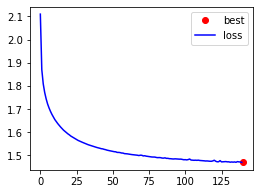

Best epoch so far:  140
Time  187.798 sec

Epoch 141 Batch 598 Loss: 1.3813
Epoch 141 Batch 1196 Loss: 1.8596
Epoch 141 Batch 1794 Loss: 1.8260
Epoch 141 Batch 2392 Loss: 1.9179
Epoch 141 Batch 2990 Loss: 1.5129
Epoch 141 Batch 3588 Loss: 1.7758

*** Epoch 141 Loss 1.4714 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a little 
%
Greedy| Q: What is your favorite restaurant ?  A: i am going to do it 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  140
Time  189.029 sec

Epoch 142 Batch 598 Loss: 1.3879
Epoch 142 Batch 1196 Loss: 1.9076
Epoch 142 Batch 1794 Loss: 1.8911
Epoch 142 Batch 2392 Loss: 1.8208
Epoch 142 Batch 2990 Loss: 1.4762
Epoch 142 Batch 3588 Loss: 1.7484

*** Epoch 142 Loss 1.4698 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not

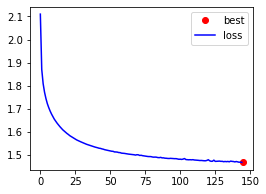

Best epoch so far:  145
Time  189.205 sec

Epoch 146 Batch 598 Loss: 1.4020
Epoch 146 Batch 1196 Loss: 1.7813
Epoch 146 Batch 1794 Loss: 1.8463
Epoch 146 Batch 2392 Loss: 1.9003
Epoch 146 Batch 2990 Loss: 1.4384
Epoch 146 Batch 3588 Loss: 1.6854

*** Epoch 146 Loss 1.4685 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a toy 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################
Best epoch so far:  145
Time  185.592 sec

Epoch 147 Batch 598 Loss: 1.3843
Epoch 147 Batch 1196 Loss: 1.9930
Epoch 147 Batch 1794 Loss: 1.8592
Epoch 147 Batch 2392 Loss: 1.9287
Epoch 147 Batch 2990 Loss: 1.4781
Epoch 147 Batch 3588 Loss: 1.8690

*** Epoch 147 Loss 1.4688 ***

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i a

In [ ]:
batch_loss = K.constant(0)
X, y = [], []
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 5 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep)
    print('Time  {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)

Now we can load our best model and chat with our system. We also plot the attention weights.

In [120]:
questions = ["how are you","you are how","You like pizza","Do you drink", "are you okay", "I am terrible","I love to travel",
             "I like swimming","I want apple","I want green apple","Who are you"]

# 5 epochs 

In [121]:
checkpoint.restore(str(emb_dim)+"-ckpt-5")


In [122]:
test_bot()


####################
Greedy| Q: Hello   A: yes 
%
Greedy| Q: How are you ?  A: i am not going to do 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to do 
%
Greedy| Q: Do you want to go out ?  A: i am not going to do 
####################


Input: how are you
Predicted answer: i am not going to do 
Attention weights
[[0.21451482 0.06407513 0.34572288]
 [0.16967024 0.17447513 0.03636261]
 [0.55601311 0.01840319 0.0236971 ]
 [0.51645547 0.116361   0.03354093]
 [0.42971301 0.1642943  0.13644969]
 [0.39399555 0.32157406 0.11376283]]


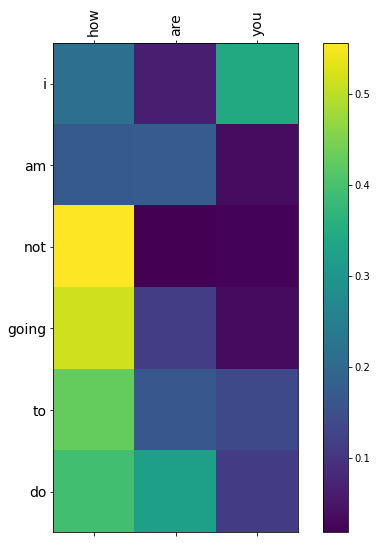


Input: you are how
Predicted answer: i am not going to do 
Attention weights
[[0.17651731 0.0493215  0.3774083 ]
 [0.16802882 0.17341587 0.03802501]
 [0.54778147 0.01926597 0.02581369]
 [0.50422895 0.10726484 0.0408611 ]
 [0.41736507 0.16138774 0.12598148]
 [0.38087133 0.33535829 0.1064555 ]]


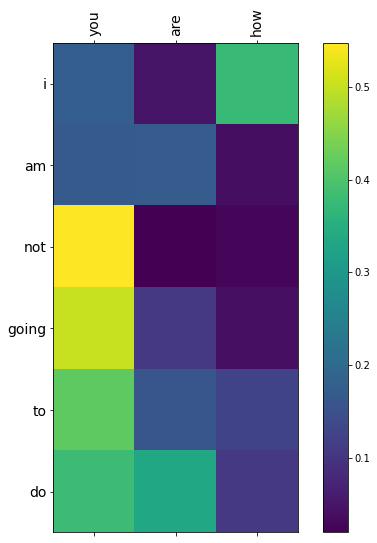


Input: you like pizza
Predicted answer: i am not going to do 
Attention weights
[[0.17194344 0.0482852  0.37407488]
 [0.16407563 0.17091751 0.03664026]
 [0.54254633 0.01843397 0.02555065]
 [0.48801166 0.11120184 0.0489942 ]
 [0.42432842 0.16216198 0.11732849]
 [0.38056874 0.34188414 0.09930645]]


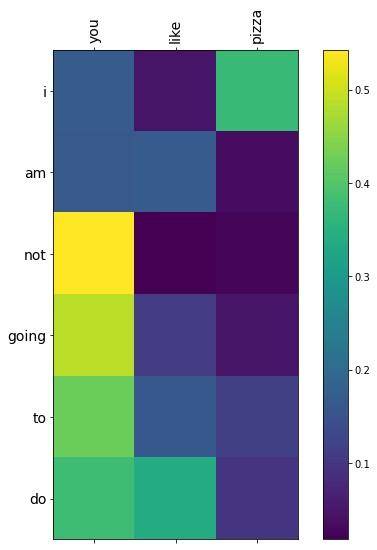


Input: do you drink
Predicted answer: i am not going to do 
Attention weights
[[0.17126092 0.04698267 0.37177789]
 [0.16620319 0.17229407 0.03665876]
 [0.54600435 0.01940557 0.02517623]
 [0.49509513 0.10596377 0.04326324]
 [0.41306609 0.16148832 0.12298678]
 [0.39041427 0.33297101 0.10436589]]


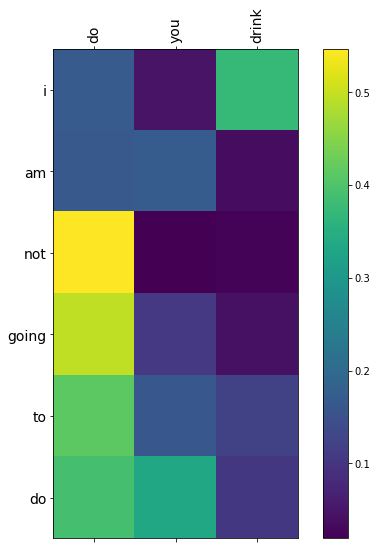


Input: are you okay
Predicted answer: i am not going to do 
Attention weights
[[0.17050858 0.04623026 0.3694936 ]
 [0.16620947 0.1702169  0.03764961]
 [0.54405755 0.01943066 0.02618803]
 [0.49657026 0.10356081 0.04252535]
 [0.40918618 0.16305882 0.12383704]
 [0.38129294 0.33294663 0.11045431]]


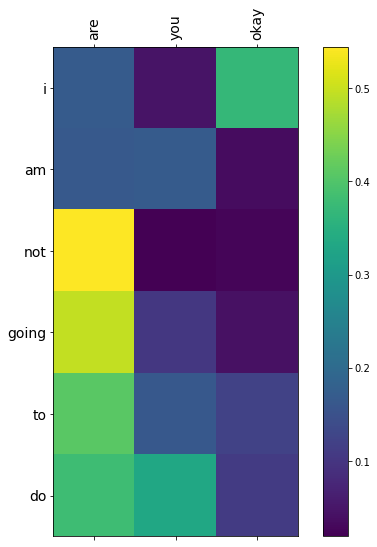


Input: i am terrible
Predicted answer: i am not going to do 
Attention weights
[[0.17560244 0.05024861 0.38090894]
 [0.16615137 0.17210999 0.03781714]
 [0.55386287 0.01858661 0.01619379]
 [0.51150483 0.09756415 0.03737981]
 [0.4226338  0.16861467 0.10095768]
 [0.38728219 0.34829298 0.0899541 ]]


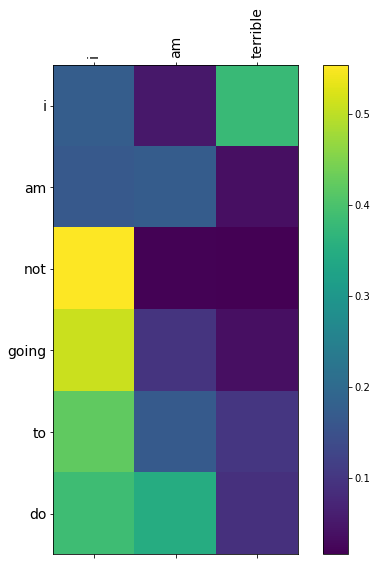


Input: i love to travel
Predicted answer: i am not going to do 
Attention weights
[[0.16380574 0.04757336 0.36222169 0.07668975]
 [0.16458735 0.17223985 0.035008   0.00447265]
 [0.54725993 0.01794497 0.01901356 0.00217818]
 [0.49451318 0.1088284  0.04382078 0.00489642]
 [0.42224216 0.16473226 0.11169434 0.0114839 ]
 [0.37049156 0.34393862 0.09919801 0.00331113]]


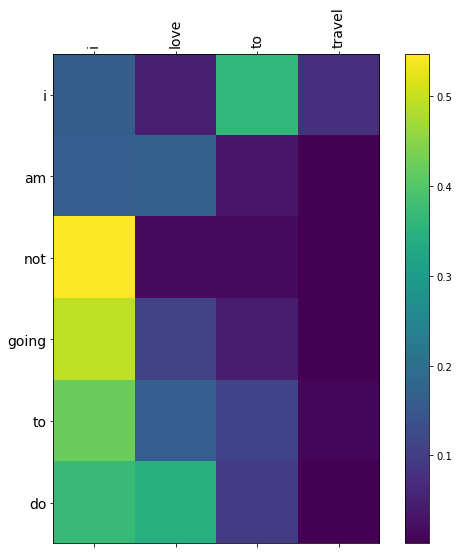


Input: i like swimming
Predicted answer: i am not going to do 
Attention weights
[[0.17902893 0.05325673 0.39412987]
 [0.16741431 0.17592384 0.03630013]
 [0.54756635 0.01813596 0.02050269]
 [0.49295631 0.10836438 0.04498461]
 [0.42698073 0.16601574 0.111268  ]
 [0.37095854 0.34613165 0.09993588]]


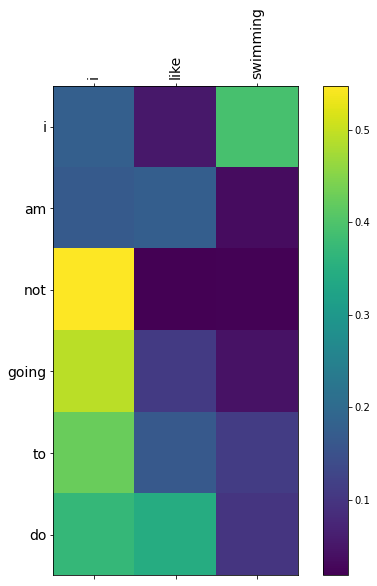


Input: i want apple
Predicted answer: i am not going to do 
Attention weights
[[0.17043217 0.04812498 0.37118462]
 [0.16471665 0.17152341 0.037254  ]
 [0.54741979 0.01876457 0.02062761]
 [0.49779576 0.10570499 0.04264763]
 [0.41520914 0.16304263 0.11750086]
 [0.3859421  0.33561367 0.10202679]]


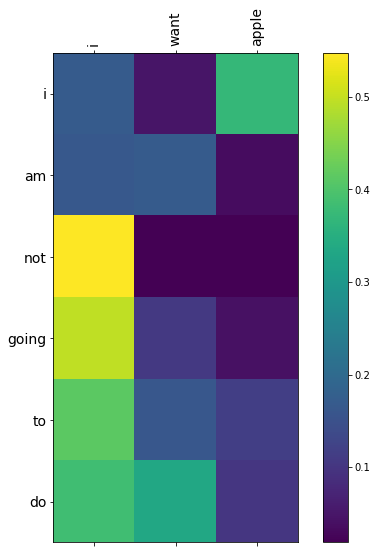


Input: i want green apple
Predicted answer: i am not going to do 
Attention weights
[[0.15870154 0.04456524 0.3443146  0.0819499 ]
 [0.16383454 0.17049718 0.03811293 0.00477751]
 [0.54625291 0.01858116 0.02066365 0.00256592]
 [0.49438104 0.10531563 0.04498238 0.00579188]
 [0.41394845 0.16197689 0.11745171 0.01415462]
 [0.38412848 0.33361059 0.10481219 0.00310371]]


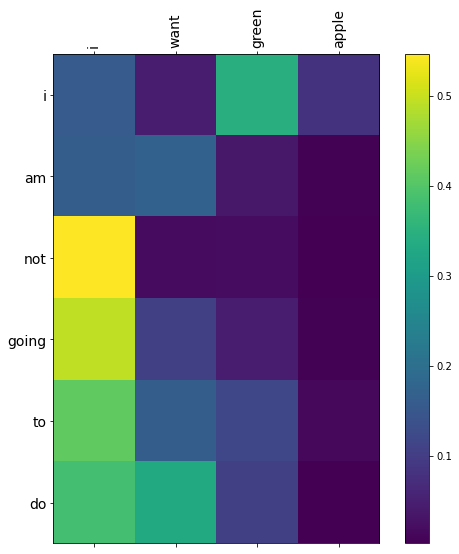


Input: who are you
Predicted answer: i am not going to do 
Attention weights
[[0.19079828 0.06467263 0.36276832]
 [0.16692235 0.17203322 0.03637096]
 [0.552284   0.01877052 0.02245564]
 [0.49138394 0.10535137 0.03929162]
 [0.42992368 0.16297846 0.11356958]
 [0.37894425 0.34575075 0.09562444]]


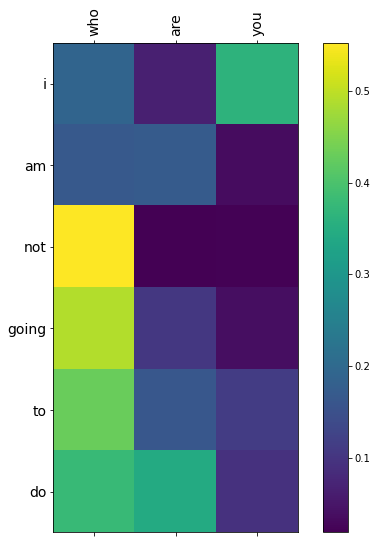

In [123]:
for question in questions:
  q = question
  answer(q,training=False)

# 50 Epochs

In [124]:
checkpoint.restore(str(emb_dim)+"-ckpt-50")

In [125]:
test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am not going to do it 
%
Greedy| Q: What are you doing ?  A: i am going to do it 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a little bit colder 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################


Input: how are you
Predicted answer: i am not going to do it 
Attention weights
[[0.15740322 0.04517081 0.36034626]
 [0.12858765 0.16052181 0.04113602]
 [0.4744162  0.01058426 0.03007702]
 [0.46650106 0.15566245 0.05356442]
 [0.38483062 0.2113042  0.19700639]
 [0.36433461 0.32787129 0.10723837]
 [0.27876952 0.22678764 0.19572255]]


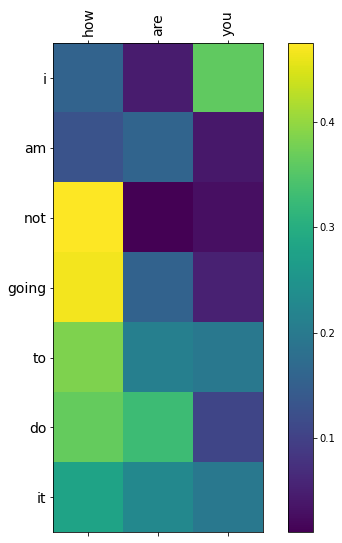


Input: you are how
Predicted answer: i am going to do it 
Attention weights
[[0.14642011 0.05314802 0.34303766]
 [0.13109089 0.16535607 0.03485742]
 [0.46129772 0.01055427 0.02839203]
 [0.36201131 0.19710614 0.12860139]
 [0.34994182 0.30019587 0.1019728 ]
 [0.2781412  0.22053155 0.20657401]]


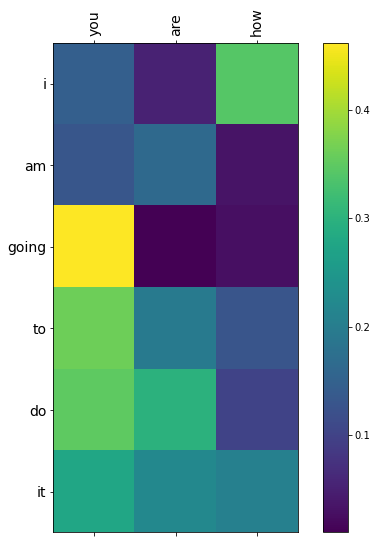


Input: you like pizza
Predicted answer: i am fine 
Attention weights
[[0.15066475 0.06222702 0.37598121]
 [0.12793058 0.14977983 0.03998571]
 [0.48301107 0.01211949 0.01811125]]


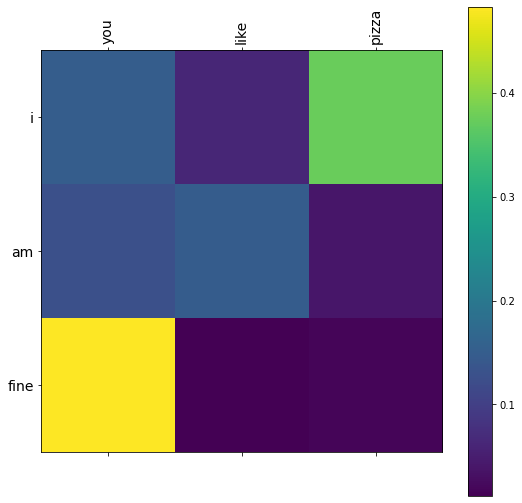


Input: do you drink
Predicted answer: no i am fine 
Attention weights
[[0.15398802 0.0646444  0.36104405]
 [0.15402387 0.08051144 0.25916842]
 [0.13091201 0.15091121 0.03247285]
 [0.47668728 0.0114971  0.01220026]]


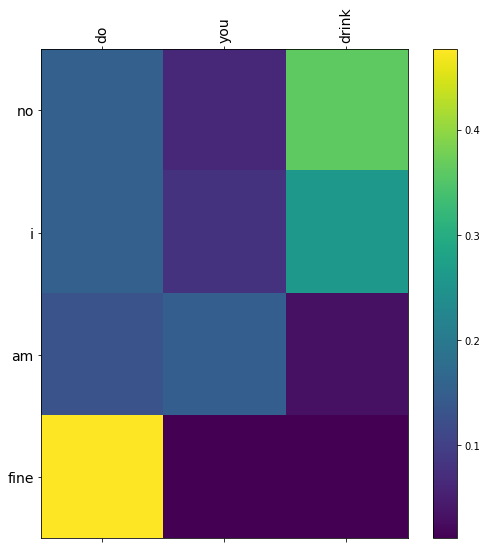


Input: are you okay
Predicted answer: i am fine 
Attention weights
[[0.14274864 0.03207013 0.32461673]
 [0.13387614 0.14450055 0.03888237]
 [0.51034647 0.01156541 0.03805745]]


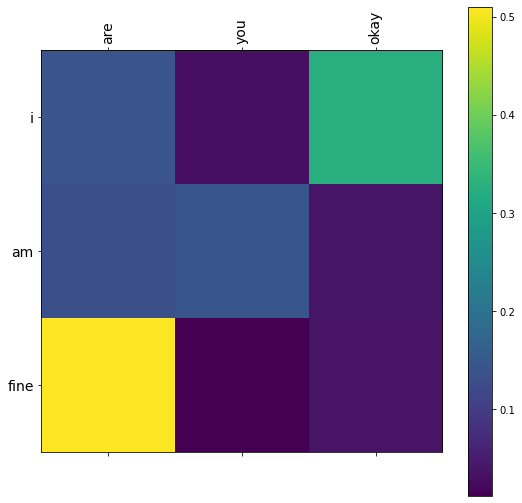


Input: i am terrible
Predicted answer: you are not going to do 
Attention weights
[[0.13375357 0.06425932 0.36063832]
 [0.23606235 0.13694879 0.04592068]
 [0.45491368 0.02686881 0.03936175]
 [0.42922211 0.04083838 0.05451974]
 [0.32938296 0.17701899 0.10061414]
 [0.33920273 0.28287229 0.0897703 ]]


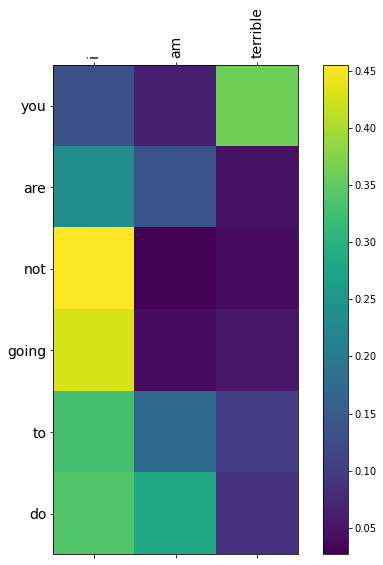


Input: i love to travel
Predicted answer: you are not going to do 
Attention weights
[[0.13549878 0.07940366 0.36362746 0.04338242]
 [0.23691759 0.11065603 0.0528915  0.00684869]
 [0.43474084 0.02903646 0.04592494 0.00308657]
 [0.4328652  0.05097225 0.05459937 0.00629589]
 [0.31632394 0.15912868 0.1062643  0.00555059]
 [0.32165247 0.31013241 0.08085552 0.00438518]]


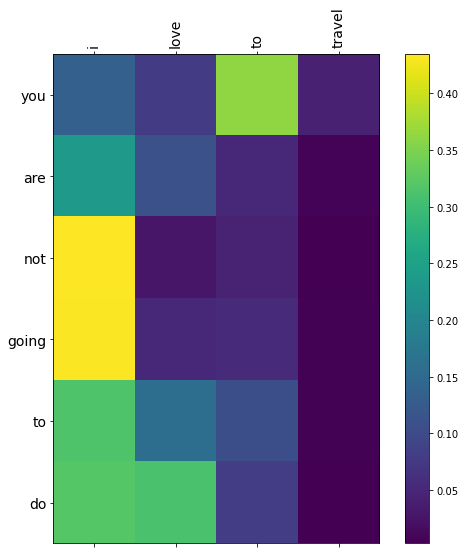


Input: i like swimming
Predicted answer: you are not going to do 
Attention weights
[[0.12182748 0.10667265 0.36458412]
 [0.22225323 0.13644212 0.05043811]
 [0.44977409 0.03394158 0.04185969]
 [0.43235654 0.05238571 0.04592089]
 [0.29250124 0.17095843 0.10323155]
 [0.35621637 0.30601418 0.08244134]]


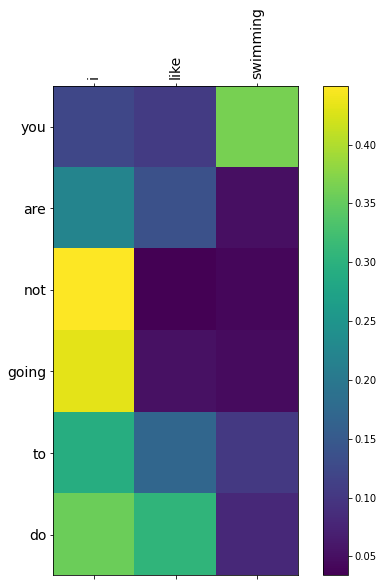


Input: i want apple
Predicted answer: i am not 
Attention weights
[[0.12685595 0.08712289 0.34413373]
 [0.14382261 0.15296759 0.0377318 ]
 [0.45203298 0.01047725 0.01754612]]


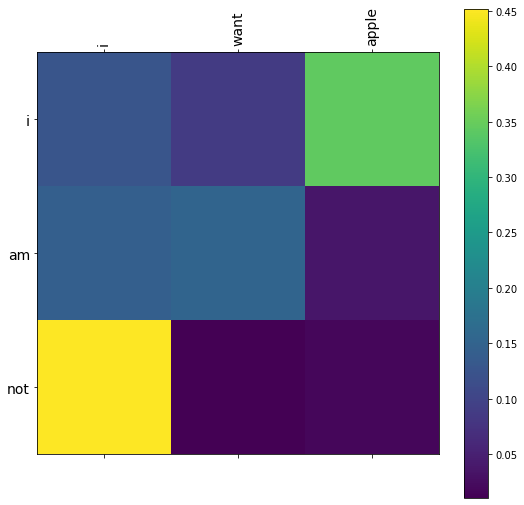


Input: i want green apple
Predicted answer: i will see you 
Attention weights
[[0.13508411 0.08095371 0.34968853 0.04954163]
 [0.13399908 0.13253978 0.04279014 0.00800862]
 [0.19430269 0.50239539 0.05584274 0.00192627]
 [0.40598407 0.29252705 0.17786983 0.00762721]]


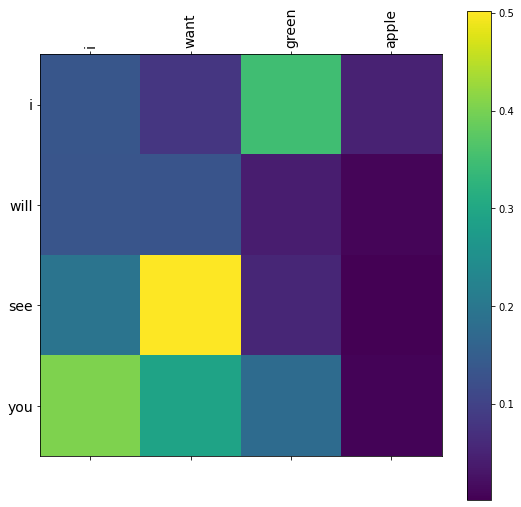


Input: who are you
Predicted answer: i am a friend 
Attention weights
[[0.15542163 0.06057387 0.37202942]
 [0.13227396 0.13750854 0.03958237]
 [0.46158373 0.00806801 0.03161173]
 [0.82338828 0.00202269 0.13860585]]


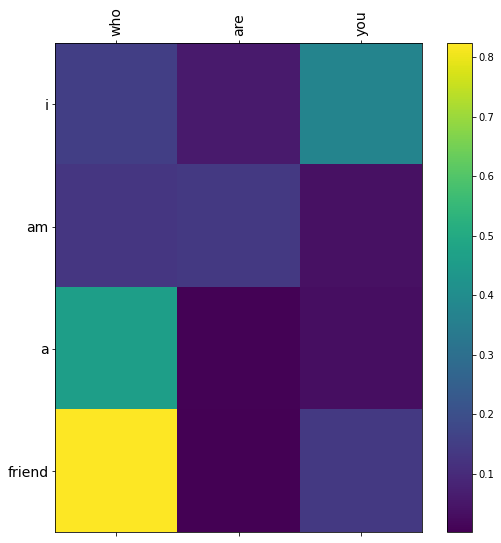

In [126]:
for question in questions:
  q = question
  answer(q,training=False)

# 149 Epochs

In [157]:
checkpoint.restore(str(emb_dim)+"-ckpt-149")

In [158]:
test_bot()

####################
Greedy| Q: Hello   A: hello 
%
Greedy| Q: How are you ?  A: i am fine 
%
Greedy| Q: What are you doing ?  A: i am not going to be a stag 
%
Greedy| Q: What is your favorite restaurant ?  A: i am not going to be a toy 
%
Greedy| Q: Do you want to go out ?  A: i am not 
####################


Input: how are you
Predicted answer: i am fine 
Attention weights
[[0.17565297 0.05595391 0.34949157]
 [0.12973119 0.16114388 0.03683675]
 [0.4662154  0.01280991 0.03037582]]


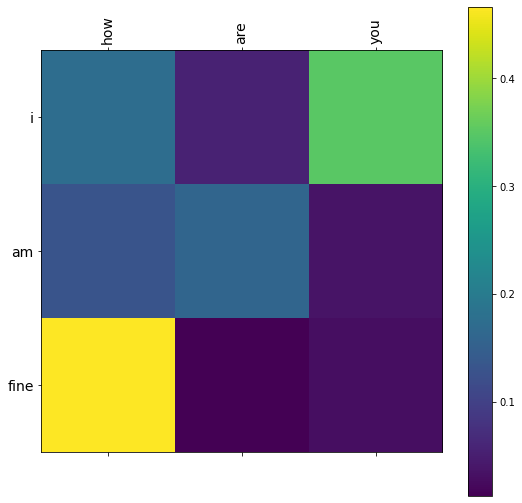


Input: you are how
Predicted answer: i am not 
Attention weights
[[0.15363663 0.07486581 0.35360345]
 [0.15415235 0.16434206 0.04728774]
 [0.45092285 0.01226228 0.06236223]]


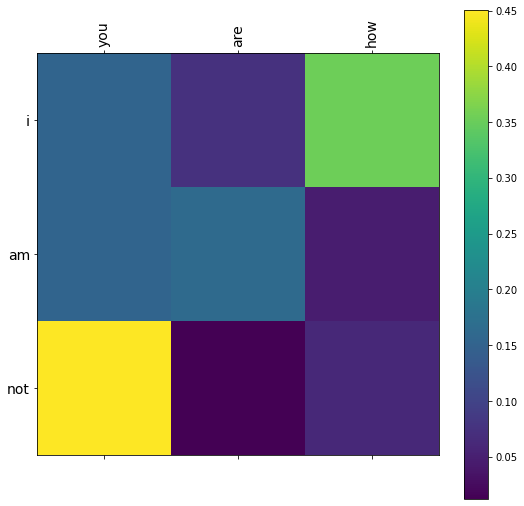


Input: you like pizza
Predicted answer: i am not letting to see you 
Attention weights
[[0.14277665 0.05446142 0.34027255]
 [0.14907487 0.15485641 0.03651091]
 [0.47142828 0.01106912 0.01632518]
 [0.46639088 0.06762467 0.07103746]
 [0.35848272 0.20199665 0.05318836]
 [0.33653939 0.30175081 0.08450016]
 [0.41559285 0.19218495 0.23145744]]


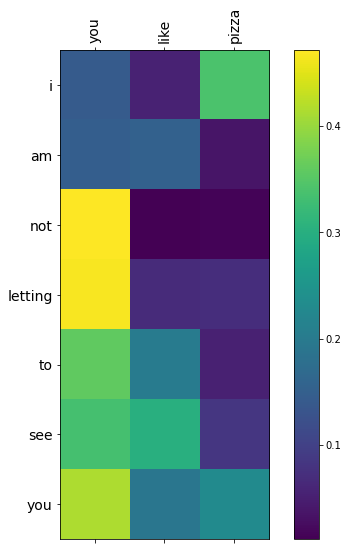


Input: do you drink
Predicted answer: no 
Attention weights
[[0.1259422  0.05896929 0.29059544]]


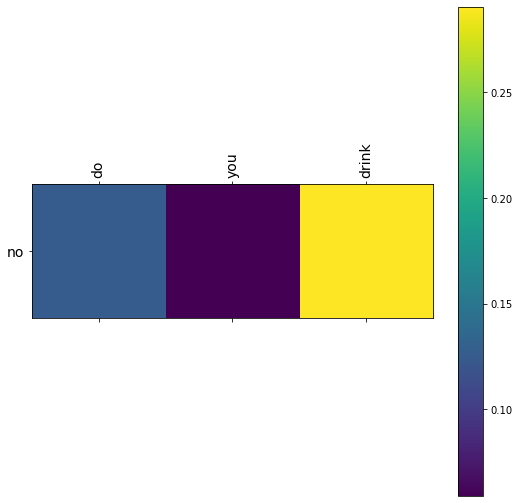


Input: are you okay
Predicted answer: i am fine 
Attention weights
[[0.15225872 0.06038636 0.31963247]
 [0.15232036 0.15272851 0.0315303 ]
 [0.48676386 0.0127223  0.03697506]]


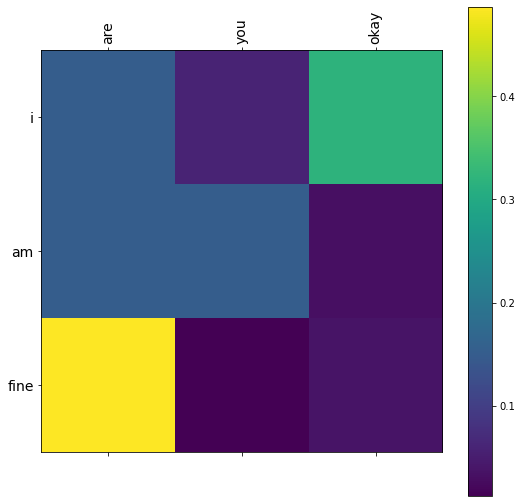


Input: i am terrible
Predicted answer: you are not 
Attention weights
[[0.13589565 0.0806643  0.33018503]
 [0.24332336 0.13119902 0.08562674]
 [0.42679021 0.02691613 0.0473013 ]]


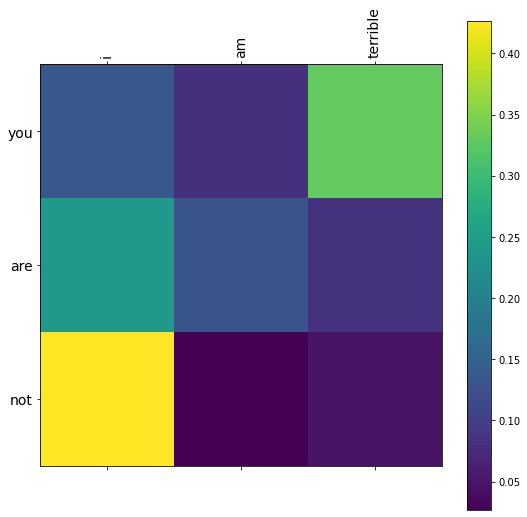


Input: i love to travel
Predicted answer: i am sorry 
Attention weights
[[0.14228354 0.0938958  0.34380069 0.03931286]
 [0.14556885 0.15252283 0.04597867 0.00202668]
 [0.46623403 0.01209749 0.01607761 0.00309187]]


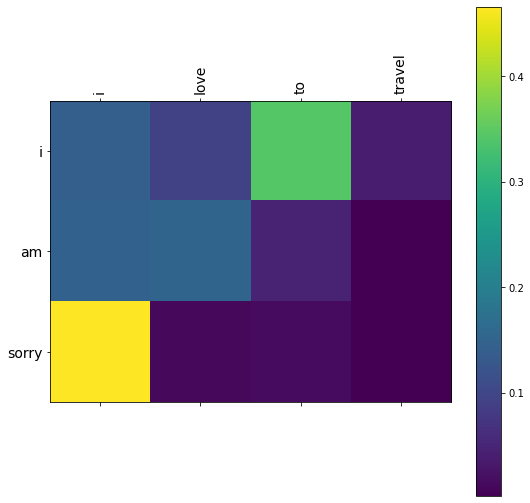


Input: i like swimming
Predicted answer: i am sorry 
Attention weights
[[0.14385433 0.10054073 0.3459374 ]
 [0.14137807 0.15270615 0.04894131]
 [0.442467   0.01208002 0.0446555 ]]


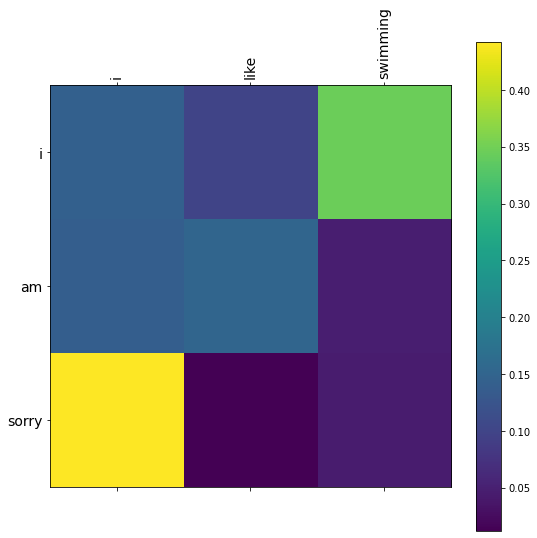


Input: i want apple
Predicted answer: you are a witch 
Attention weights
[[0.14443894 0.08203866 0.35266376]
 [0.2219083  0.16702375 0.08747175]
 [0.40781003 0.04095739 0.04513777]
 [0.79230928 0.01222141 0.12326671]]


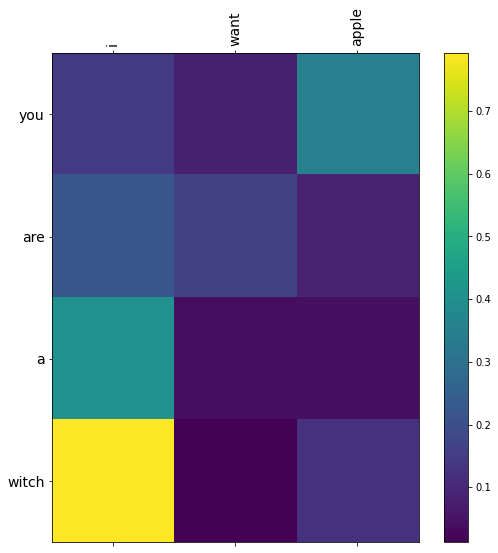


Input: i want green apple
Predicted answer: i will do it 
Attention weights
[[0.13197203 0.07526299 0.32328698 0.04561414]
 [0.14465167 0.15472691 0.04783836 0.00871883]
 [0.19725223 0.47486791 0.06176136 0.00406032]
 [0.26993108 0.20300172 0.1430182  0.00617484]]


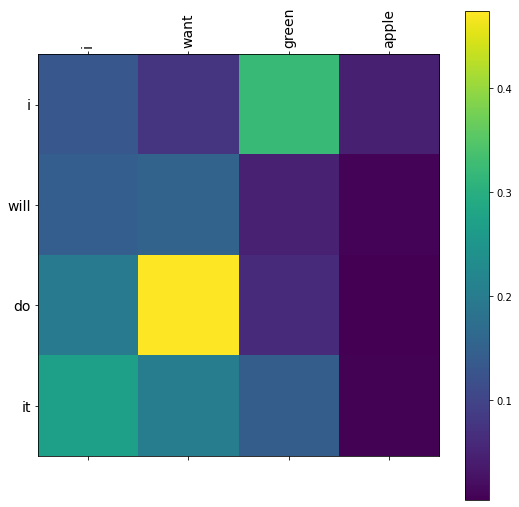


Input: who are you
Predicted answer: i am a messenger 
Attention weights
[[0.15253066 0.05094404 0.35142842]
 [0.14498536 0.14603473 0.03796625]
 [0.45358804 0.01007298 0.06932885]
 [0.83011675 0.00482809 0.09928391]]


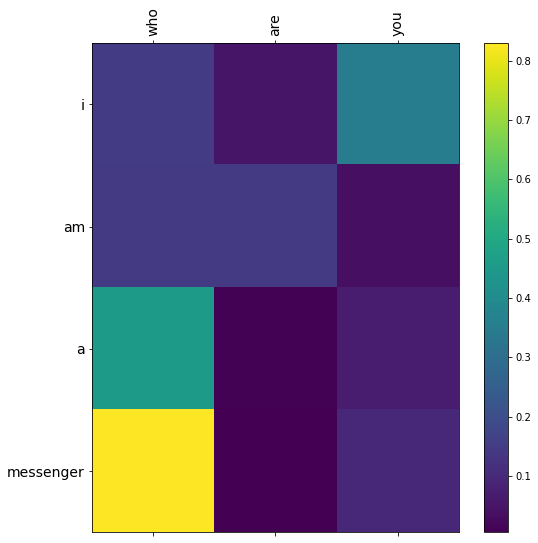

In [159]:
for question in questions:
  q = question
  answer(q,training=False)

Input: i like pool
Predicted answer: you are interrupting 
Attention weights
[[0.14172095 0.10188598 0.3458223 ]
 [0.25105575 0.13593622 0.10371785]
 [0.42502797 0.03616229 0.03332723]]


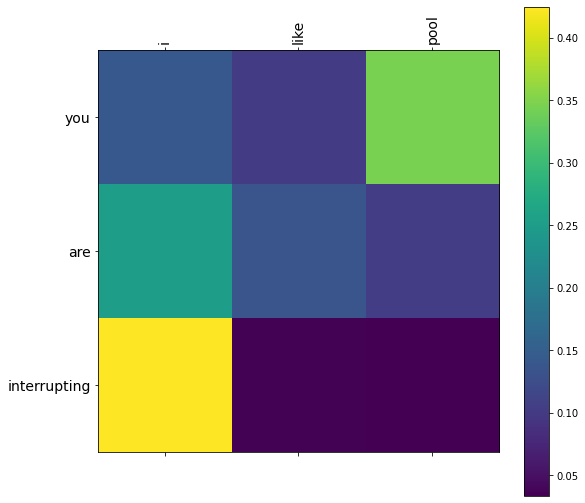

In [160]:
q = "I like pool"
answer(q,training=False)

Input: you look terrible
Predicted answer: i am not 
Attention weights
[[0.14160623 0.05699256 0.33781287]
 [0.14954841 0.15310536 0.03327584]
 [0.45566121 0.01178666 0.01801531]]


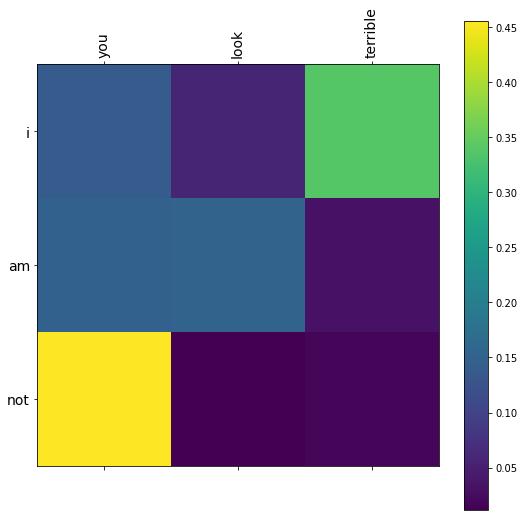

In [166]:
q = "you look terrible"
answer(q,training=False)

Input: was it raining
Predicted answer: i am sorry 
Attention weights
[[0.15277597 0.08257128 0.36049286]
 [0.13861828 0.15059361 0.04442581]
 [0.47388533 0.00663077 0.01693965]]


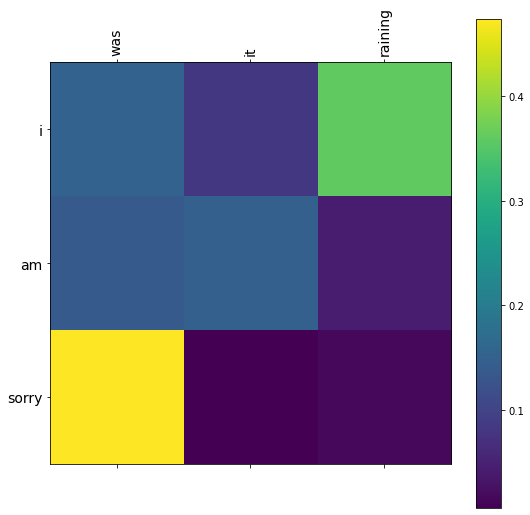

In [175]:
q ="was it raining"
answer(q,training=False)

Input: i love cricket
Predicted answer: you are not 
Attention weights
[[0.15404086 0.08376351 0.38167024]
 [0.24144952 0.13016307 0.08415365]
 [0.43526223 0.03125087 0.04783693]]


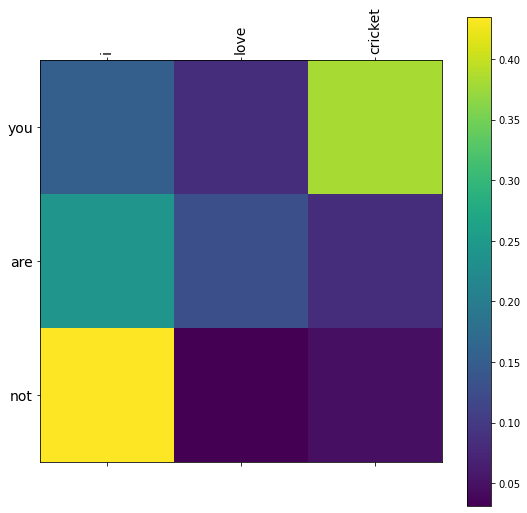

In [161]:
q = "i love cricket"
answer(q,training=False)